In [4]:
import differential as diff
import numpy as np
import pandas as pd
import csv

def load_data_from_csv(filename):
    ts = []
    Vs = []
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)
        for row in reader:
            ts.append(float(row[0]))
            Vs.append(float(row[1]))
    return ts, Vs

# Load the data 
filename = input("Enter the CSV file name (e.g., 'data.csv'): ")
ts, Vs = load_data_from_csv(filename)


Model: Mendelsohn, AIC: 63.217952


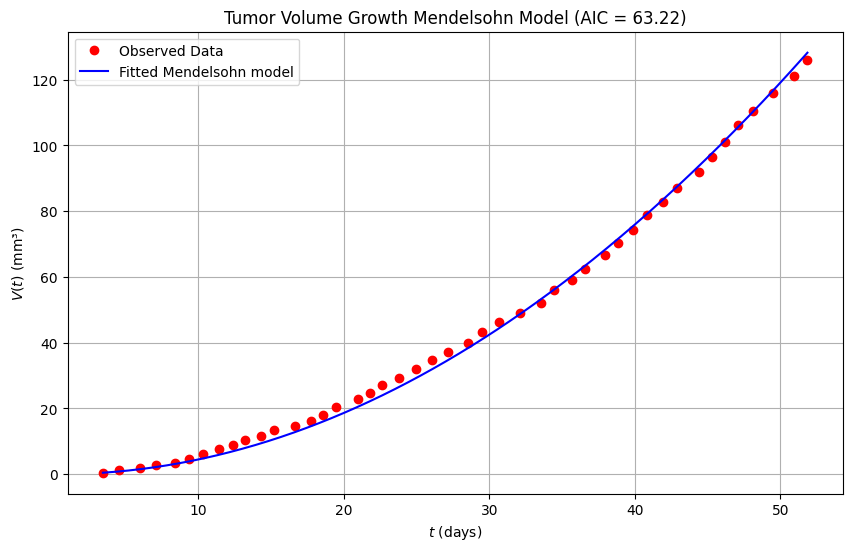

Model: Gompertz, AIC: 193.633662


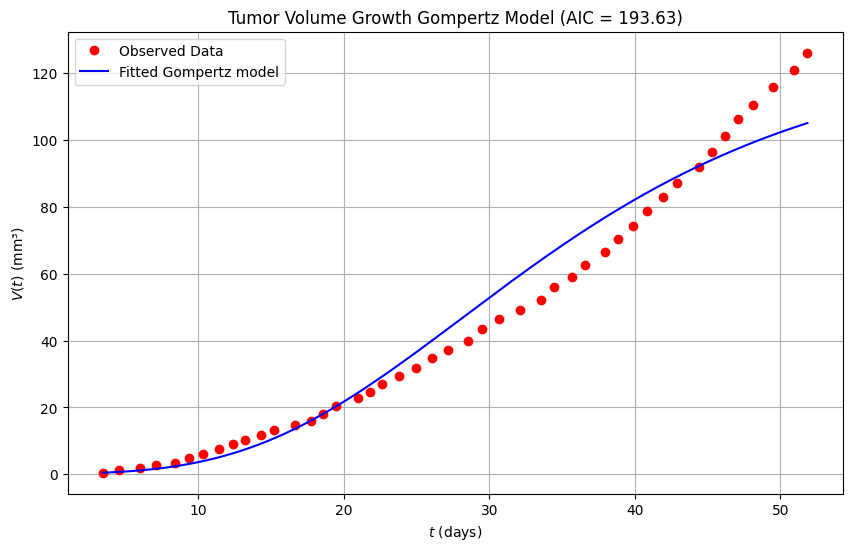

Model: Von Bertalanffy, AIC: 197.534899


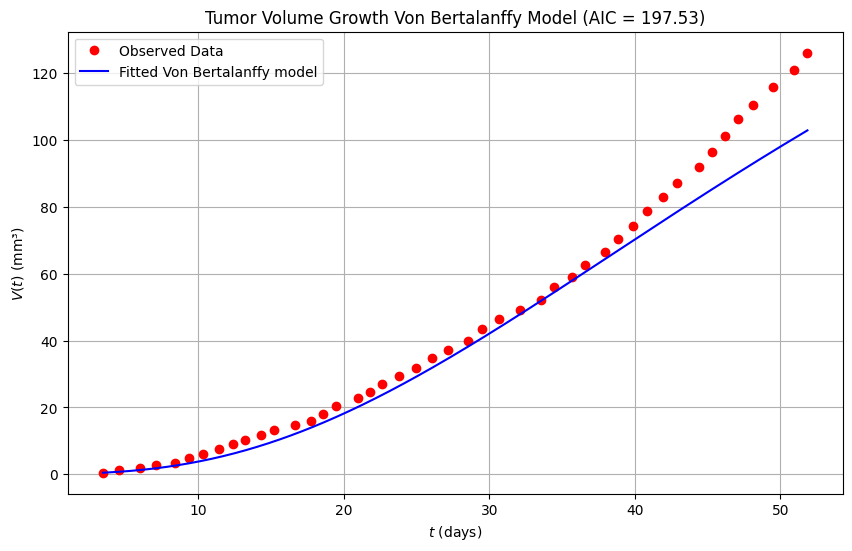

Model: Linear Model, AIC: 233.970637


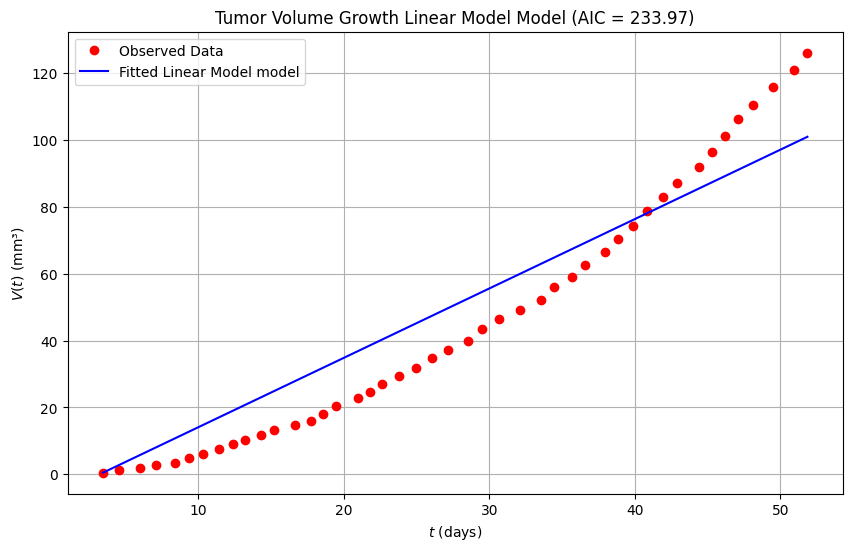

Model: Exponential Growth, AIC: 302.764849


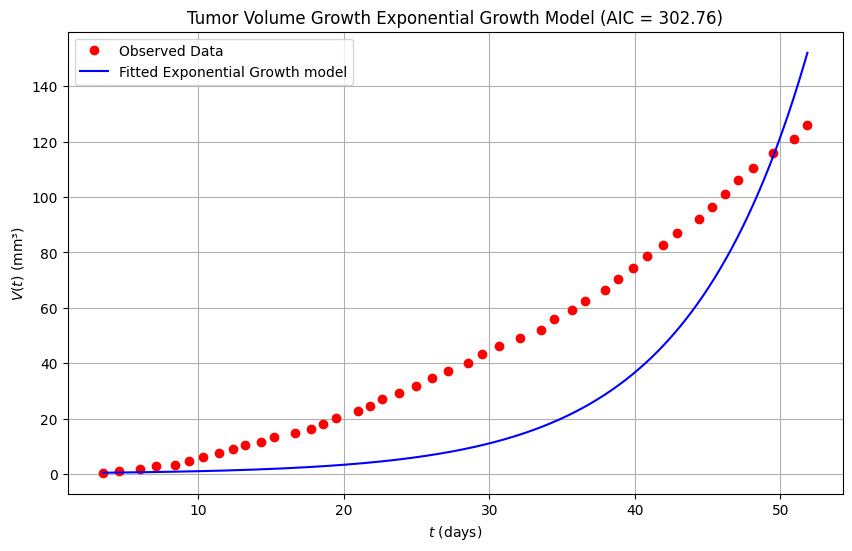

Model: Allee Effect Growth, AIC: 404.045025


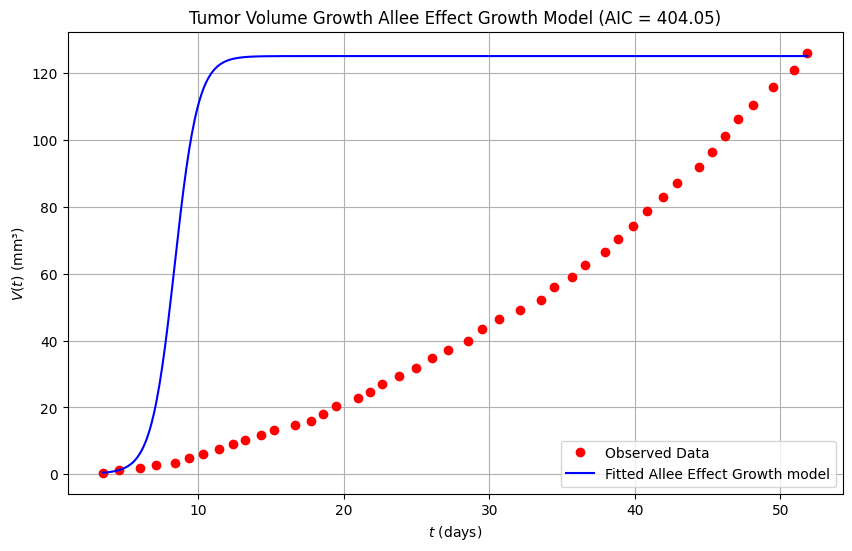

Model: Combined Growth, AIC: 407.14024


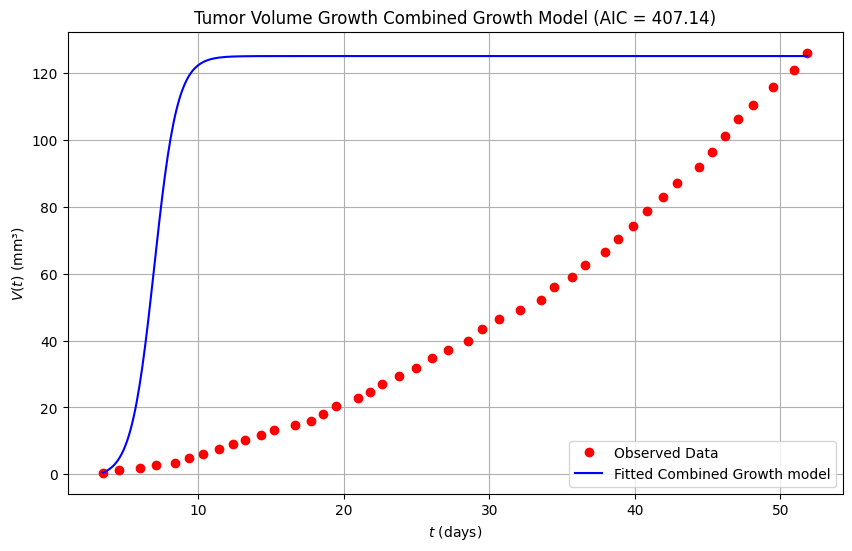

In [9]:
gompertz_mse, gompertz_params, gompertz_ts, gompertz_Vs = diff.gompertz(ts, Vs)
mendelsohn_mse, mendelsohn_params, mendelsohn_ts, mendelsohn_Vs = diff.mendelsohn(ts, Vs)
vb_mse, vb_ts, vb_Vs = diff.von_bertalanffy(ts, Vs)
linear_mse, linear_ts, linear_Vs = diff.linear_growth(ts, Vs)
exponential_mse, exponential_params, exponential_ts, exponential_Vs = diff.exponential_growth(ts, Vs)
allee_effect_mse, allee_effect_params, allee_effect_ts, allee_effect_Vs = diff.allee_effect(ts, Vs)
combined_mse, combined_params, combined_ts, combined_Vs = diff.combined_growth(ts, Vs)

# Prepare the models for comparison
models = [
    {'name': 'Gompertz', 'x': gompertz_ts, 'y': gompertz_Vs, 'mse': gompertz_mse},
    {'name': 'Mendelsohn', 'x': mendelsohn_ts, 'y': mendelsohn_Vs, 'mse': mendelsohn_mse},
    {'name': 'Von Bertalanffy', 'x': vb_ts, 'y': vb_Vs, 'mse': vb_mse},
    {'name': 'Linear Model', 'x': linear_ts, 'y': linear_Vs, 'mse': linear_mse},
    {'name': 'Exponential Growth', 'x': exponential_ts, 'y': exponential_Vs, 'mse': exponential_mse},
    {'name': 'Allee Effect Growth', 'x': allee_effect_ts, 'y': allee_effect_Vs, 'mse': allee_effect_mse},
    {'name': 'Combined Growth', 'x': combined_ts, 'y': combined_Vs, 'mse': combined_mse},
]

n = len(ts)

for model in models:
    rss = model['mse'] * n
    ln_likelihood = -n / 2 * np.log(rss / n)
    model['aic'] = 2 * len(models) - 2 * ln_likelihood
for model in sorted(models, key=lambda x: x['aic']):
    aic = model['aic']
    print(f'Model: {model["name"]}, AIC: {round(aic,6)}')

    label = f'Fitted {model["name"]} model'
    title = f'Tumor Volume Growth {model["name"]} Model (AIC = {round(aic,2)})'
    diff.plot(ts,Vs,model['x'],model['y'],label,title)


In [10]:
results = {'model': [], 'formula': [], 'BIC': [], 'AIC': [], 'AICc': []}

for model_function in [diff.gompertz, diff.mendelsohn, diff.von_bertalanffy, diff.linear_growth, diff.exponential_growth, diff.allee_effect, diff.combined_growth]:
    model_name = model_function.__name__.capitalize()
    
    try:
        mse, params, fitted_ts, fitted_Vs = model_function(ts, Vs)
    except ValueError: 
        mse, fitted_ts, fitted_Vs = model_function(ts, Vs)
        params = []
    
    # Calculate AIC/BIC/AICc
    n = len(ts)
    k = len(params)
    ln_mse = np.log(mse)
    
    aic = n * ln_mse + 2 * k
    bic = k * ln_mse + np.log(n)
    aicc = aic + (2 * k * n) / (n - k - 1) if n > k + 1 else aic

    # Formulas per model
    if model_name == "Gompertz":
        formula = "dV/dt = c * V * ln(Vmax / V)"
    elif model_name == "Mendelsohn":
        formula = "dV/dt = c * V^d"
    elif model_name == "Von_bertalanffy":
        formula = "dV/dt = c * V^(2/3) - d * V"
    elif model_name == "Linear_growth":
        formula = "dV/dt = c"
    elif model_name == "Exponential_growth":
        formula = "dV/dt = c * V"
    elif model_name == "Allee_effect":
        formula = "dV/dt = c * (V - Vmin) * (Vmax - V)"
    elif model_name == "Combined_growth":
        formula = "dV/dt = c1 * (Vmax - V) + c2 * V * (Vmax - V)"
    else:
        formula = "Onbekend"

    # Save results
    results['model'].append(model_name)
    results['formula'].append(formula)
    results['BIC'].append(bic)
    results['AIC'].append(aic)
    results['AICc'].append(aicc)

# Create DataFrame and sort
pd.DataFrame(results).set_index('model').sort_values('BIC')


,formula,BIC,AIC,AICc
model,,,,
Linear_growth,dV/dt = c,3.806662,219.970637,219.970637
Von_bertalanffy,dV/dt = c * V^(2/3) - d * V,3.806662,183.534899,183.534899
Mendelsohn,dV/dt = c * V^d,5.994127,53.217952,57.503667
Exponential_growth,dV/dt = c * V,10.223659,290.764849,292.857872
Gompertz,dV/dt = c * V * ln(Vmax / V),11.790381,183.633662,187.919376
Allee_effect,dV/dt = c * (V - Vmin) * (Vmax - V),29.809664,396.045025,402.630391
Combined_growth,dV/dt = c1 * (Vmax - V) + c2 * V * (Vmax - V),30.016012,399.140240,405.725606
